In [2]:
# Read from Datasets/ECG5000/ECG5000_TEST.txt

import numpy as np
import matplotlib.pyplot as plt

# Read from Datasets/ECGFiveDays/ECGFiveDays_TEST.txt, and get the first column as the labels
true_labels = np.genfromtxt('Datasets/ElectricDevices/ElectricDevices_TEST.txt', delimiter=' ', usecols=0)

# Read from Datasets/ECGFiveDays/ECGFiveDays_TEST.txt
data = np.genfromtxt('Datasets/ElectricDevices/ElectricDevices_TEST.txt', delimiter='  ', usecols=range(1,97))

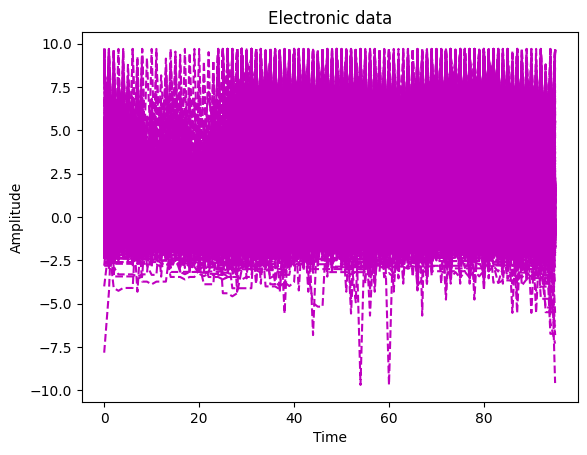

In [3]:
# Plot the data
for i in range(len(data)):
    if true_labels[i] == 0:
        plt.plot(data[i], linestyle='--', color='b')
    elif true_labels[i] == 1:
        plt.plot(data[i], linestyle='--', color='r')
    elif true_labels[i] == 2:
        plt.plot(data[i], linestyle='--', color='g')
    elif true_labels[i] == 3:
        plt.plot(data[i], linestyle='--', color='c')
    elif true_labels[i] == 4:
        plt.plot(data[i], linestyle='--', color='y')
    elif true_labels[i] == 5:
        plt.plot(data[i], linestyle='--', color='k')
    else:
        plt.plot(data[i], linestyle='--', color='m')
plt.title('Electronic data')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.show()


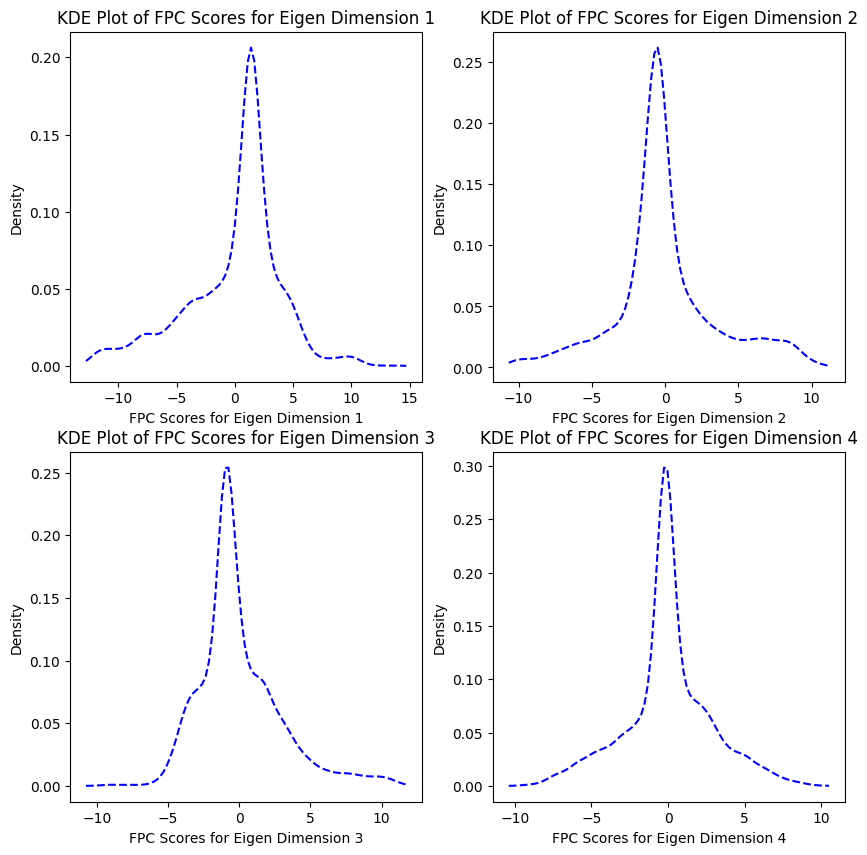

In [6]:
import scipy
from scipy import spatial, interpolate
from ensemble_clustering import functional_data_decomposition, functional_data_clustering
from fda_results import percentage_variation_ami_ari, plot_percentage_variation_ami_ari

data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (data, 10, 250)

# For loop to plot a 2x2 set of scatter plots for the kernel density plots of the first four principal components
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
    # Kernel density plot for principal components[i], as a scatter plot
    # Determine the desnity of principal components[i]
    kde = scipy.stats.gaussian_kde(principal_componenets[:,i])
    # Create a grid of points
    x_grid = np.linspace(min(principal_componenets[:,i]), max(principal_componenets[:,i]), 100)
    # Evaluate the density on the grid
    density = kde(x_grid)
    # Plot the density
    ax[i//2, i%2].plot(x_grid, density, color='b', linestyle='--')
    ax[i//2, i%2].set_title('KDE Plot of FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_xlabel('FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_ylabel('Density')
plt.show()

Percentage of variation explained by each eigen dimensions:  [0.2221811  0.16845556 0.11258277 0.10658145 0.08104826 0.07678941
 0.06287062 0.06121167 0.05460446 0.0536747 ]


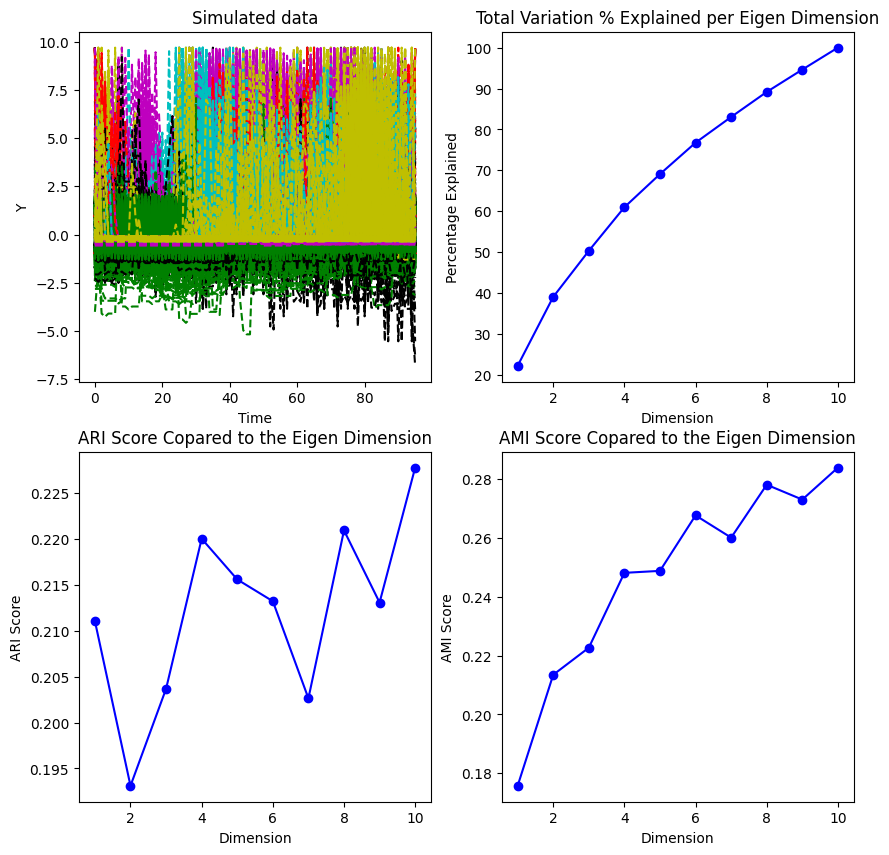

In [8]:
variance, ami, ari, v_range = percentage_variation_ami_ari(10, data, 150, true_labels, 7)
plot_percentage_variation_ami_ari(variance, ami, ari, v_range, true_labels, data)

In [13]:
# Determine the Eigen Dimension that explains 95% of the variance
for i in range(len(variance)):
    if sum(variance[:i+1]) >= 0.95:
        print('The Eigen Dimension that explains 95% of the variance is ' + str(i))
        V = i
        break

The Eigen Dimension that explains 95% of the variance is 9


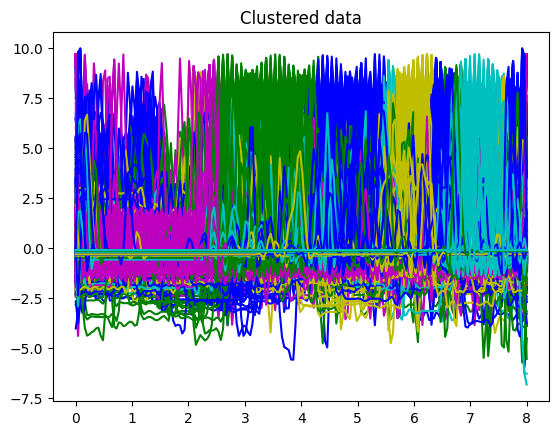

AMI score: 0.217191
ARI score: 0.257155


In [14]:
# Get data from the first function
data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (data, 9, 200)

# Get data from the second function
membership_matrices, labels = functional_data_clustering (principal_componenets, 5)

# Plot the curves with their labels
t = np.expand_dims(np.linspace(0, 8, len(data_smooth[0])), 1)
for i in range(len(data_smooth)):
    if labels[i] == 0:
        plt.plot(t, data_smooth[i], '-m')
    elif labels[i] == 1:
        plt.plot(t, data_smooth[i], '-b')
    elif labels[i] == 2:
        plt.plot(t, data_smooth[i], '-g')
    elif labels[i] == 3:
        plt.plot(t, data_smooth[i], '-c')
    elif labels[i] == 4:
        plt.plot(t, data_smooth[i], '-y')
    elif labels[i] == 5:
        plt.plot(t, data_smooth[i], '-k')
    else:
        plt.plot(t, data_smooth[i], '-r')
plt.title('Clustered data')
plt.show()

from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

print("AMI score: %f" % adjusted_mutual_info_score(true_labels, labels))
print("ARI score: %f" % adjusted_rand_score(true_labels, labels))